## In this Notebook, we will create a basic Q&A chain and Agent over a SQL database

### Architecture

At a high-level, the steps of any SQL chain and agent are:

- `Convert question to SQL query using the LLM Model.`
- `Execute the SQL query.`
- `getting the Model to respond to user input using the query results.`

In [1]:
from langchain.utilities import SQLDatabase
from langchain.chat_models import ChatOpenAI
from langchain.chains import create_sql_query_chain
from langchain_openai import ChatOpenAI


In [14]:
llm = ChatOpenAI(temperature=0)

In [15]:
host = '0.0.0.0'
port = '5432'
username = 'odin'
password = 'odin'
db_name = 'analytics'
postgres_connection = f"postgresql://{username}:{password}@{host}:{port}/{db_name}"

db = SQLDatabase.from_uri(postgres_connection, sample_rows_in_table_info=2)
chain = create_sql_query_chain(llm, db)

In [16]:
print(db.dialect)
print(db.get_usable_table_names())

postgresql
['customer', 'sale']


In [17]:
db.run("SELECT count(*) FROM customer LIMIT 10;")

'[(1000,)]'

In [18]:
response = chain.invoke({"question": "How many customer are there"})
response

'SELECT COUNT(customerid) AS total_customers FROM customer;'

In [19]:
db.run(response)

'[(1000,)]'

In [20]:
response = chain.invoke({"question": "How many customers are from Bronx"})
print(response)

SELECT COUNT(*) 
FROM customer 
WHERE city = 'Bronx' 
LIMIT 5;


In [21]:
print(db.run(response))

[(2,)]


In [22]:
response = chain.invoke({"question": "Which state are customers most from?"})
print(response)


SELECT "state_", COUNT(*) as state_count
FROM customer
GROUP BY "state_"
ORDER BY state_count DESC
LIMIT 1;


In [23]:
print(db.run(response))

[('CA', 79)]


In [103]:
response = chain.invoke({"question": "Give me the top 5 customers who paid the highest shipping charges"})
print(response)


SELECT c.customerid, c.firstname, c.lastname, s.shipping
FROM customer c
JOIN sale s ON c.customerid = s.customerid
ORDER BY s.shipping DESC
LIMIT 5;


In [80]:
class Payment:
    id: int
    name: str
    surname: str
    shipping: float

    def __init__(
            self,
            id: int,
            name: str,
            surname: str,
            shipping: float) -> None:
        self.id = id
        self.name = name
        self.surname = surname
        self.shipping = shipping

    @staticmethod
    def from_tuple(data: tuple):
        return Payment(
            id = data[0],
            name = data[1],
            surname = data[2],
            shipping = data[3],
        )
    
    def __str__(self) -> str:
        return f"""
            id: {self.id}
            name: {self.name}
            surname: {self.surname}
            shipping: {self.shipping}
        """
    
    def to_dict(self) -> dict:
        return {
            'id': self.id,
            'name': self.name,
            'surname': self.surname,
            'shipping': self.shipping
        }

class Customer:
    customerid: int 
    firstname: str 
    lastname: str 
    streetaddress: str 
    city: str 
    state_: str 
    postalcode: str 
    country: str
    phone: str

    def __init__(
            self,
            customerid: int,
            firstname: str ,
            lastname: str ,
            streetaddress: str, 
            city: str ,
            state_: str, 
            postalcode: str, 
            country: str,
            phone: str  
        ) -> None:
        self.customerid = customerid
        self.firstname = firstname
        self.lastname = lastname
        self.streetaddress = streetaddress 
        self.city =  city
        self.state_ = state_
        self.postalcode = postalcode
        self.country = country
        self.phone = phone

    @staticmethod
    def from_tuple(customer: tuple) :
        return Customer(
                customerid = customer[0],
                firstname = customer[1],
                lastname = customer[2],
                streetaddress = customer[3], 
                city =  customer[4],
                state_ = customer[5],
                postalcode = customer[6],
                country = customer[7],
                phone = customer[8]
            )

    def to_dict(self) -> dict:
        return {
           "customerid": self.customerid,
           "firstname": self.firstname,
           "lastname": self.lastname,
           "streetaddress": self.streetaddress,
           "city": self.city,
           "state_": self.state_,
           "postalcode": self.postalcode,
           "country": self.country,
           "phone": self.phone
        }

In [104]:
res = db.run(response)

In [105]:
import ast

payments = []

for item in ast.literal_eval(res):
    payments.append(Payment.from_tuple(data=item))

In [106]:
import pandas as pd

users_dicts = [item.to_dict() for item in payments]

df = pd.DataFrame(users_dicts)

print(df)

     id         name     surname  shipping
0  1096       Meliha     Handzic     59.37
1  1950         Jack      Freund     54.45
2   724  Epaminondas  Kapetanios     54.41
3  3979         Glen    Quintana     54.39
4  1385        Peter       Pille     52.88


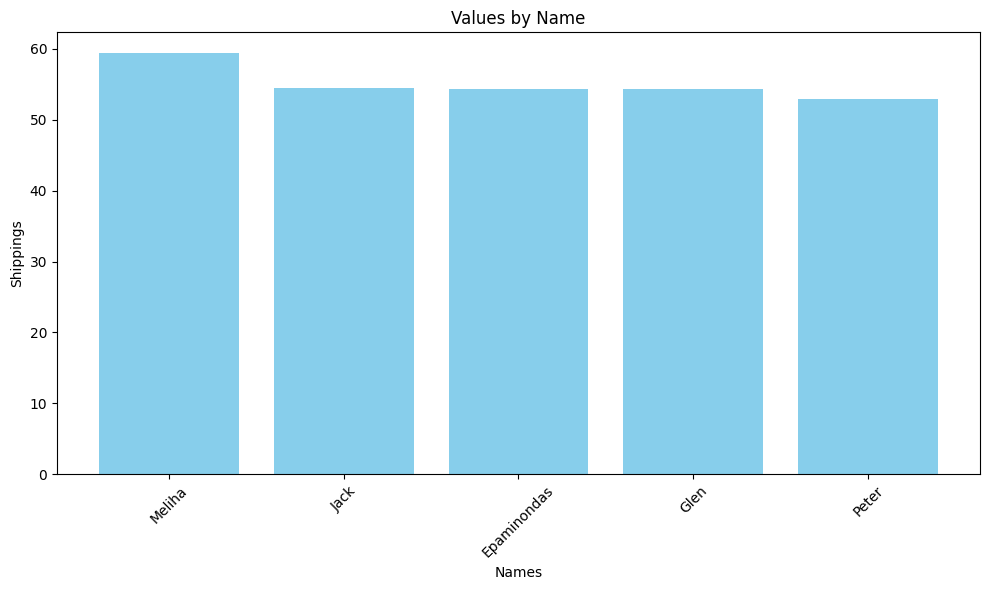

In [107]:
import matplotlib.pyplot as plt 

# Extracting 'name' and 'value' columns
names = df['name']
values = df['shipping']

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(names, values, color='skyblue')
plt.xlabel('Names')
plt.ylabel('Shippings')
plt.title('Values by Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [86]:
response = chain.invoke({"question": "Give me the last 10 customer ordered by first name"})

In [87]:
res = db.run(response)

customers = []

for item in ast.literal_eval(res):
    customers.append(Customer.from_tuple(item))

In [88]:
customers_dicts = [item.to_dict() for item in customers]

pd.DataFrame(customers_dicts)

,customerid,firstname,lastname,streetaddress,city,state_,postalcode,country,phone
0,727,Zhiyan,Hu,Po Box 3726,El Centro,CA,92244,USA,(760) 352-4913
1,500,Zaheeruddin,Asif,46 Mary Ave,East Providence,RI,02914,USA,(401) 434-1321
2,2006,Yvonne,Weber,2416 S 13th St,Temple,TX,76504,USA,(254) 770-0397
3,1129,Yungchang,Ku,1951 Liko Pl,Wailuku,HI,96793,USA,(808) 244-5817
4,1276,Yuan-Hong,Liu,3 Twiller St,Albany,NY,12209,USA,(518) 462-4608
5,3906,Young-Woo,Sohn,805 E 8th Ave,Kingman,KS,67068,USA,(620) 532-5217
6,927,Yoichi,Terashita,2110 9th St,Sanger,CA,93657,USA,(559) 875-3682
7,819,Yishu.Aileen,Ding,851 Lott Rd,Pocatello,ID,83201,USA,(208) 637-8209
8,1801,Yaniv,Vakrat,33 Booker St,Hampton,VA,23663,USA,(757) 788-8500
9,2372,Yang,Lee,3501 S Randi Pl,Tucson,AZ,85730,USA,(520) 885-2081


In [92]:
response = chain.invoke({"question": "Give me firts 3 sales shipping and the customer name"})

In [93]:
print(response)

SELECT s.shipping, c.firstname, c.lastname
FROM sale s
JOIN customer c ON s.customerid = c.customerid
ORDER BY s.saleid
LIMIT 3;


In [94]:
res = db.run(response)

print(res)

[(44.37, 'Xiafeng', 'Wang'), (9.95, 'Herschel', 'Webster'), (39.05, 'John', 'Hebeler')]


In [97]:
prompt_with_context = chain.get_prompts()[0].partial(table_info=context["table_info"])
print(prompt_with_context.pretty_repr()[:1500])

You are a PostgreSQL expert. Given an input question, first create a syntactically correct PostgreSQL query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per PostgreSQL. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use CURRENT_DATE function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLR

In [98]:
context = db.get_context()
print(list(context))
print(context["table_info"])

['table_info', 'table_names']

CREATE TABLE customer (
	customerid BIGINT, 
	firstname VARCHAR(1024), 
	lastname VARCHAR(1024), 
	streetaddress VARCHAR(1024), 
	city VARCHAR(1024), 
	state_ VARCHAR(1024), 
	postalcode VARCHAR(1024), 
	country VARCHAR(1024), 
	phone VARCHAR(1024)
)

/*
2 rows from customer table:
customerid	firstname	lastname	streetaddress	city	state_	postalcode	country	phone
12	James	Dominick	4 Mast Ct	Portsmouth	VA	23703	USA	(757) 686-2992
17	Fredric	Wagner	11 May St	Enfield	NH	03748	USA	(603) 632-7463
*/


CREATE TABLE sale (
	saleid BIGINT, 
	saledate VARCHAR(1024), 
	customerid BIGINT, 
	tax DOUBLE PRECISION, 
	shipping DOUBLE PRECISION
)

/*
2 rows from sale table:
saleid	saledate	customerid	tax	shipping
191228	2013-12-31	1134	0.0	44.37
191229	2013-12-31	14958	0.0	9.95
*/
